<a href="https://colab.research.google.com/github/rsonthal/Under-Parameterized-Double-Descent/blob/main/Regularized_Experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import numpy as np
import sympy as sym
from sympy.solvers import solve
from tqdm import tqdm

from matplotlib import pyplot as plt

# torch.set_default_device("cuda")

In [ ]:



def calc_lambda_inverse_N(c,mu):
  b = -(1-c+mu**2)
  a = -c*mu**2
  cq = 1
  numerator1 = -1*b - np.sqrt(b ** 2 - 4*a*cq)
  numerator2 = -1*b + np.sqrt(b ** 2 - 4*a*cq)
  denominator = 2*a
  return numerator1/denominator

def calc_lambda_inverse_M(c,mu):
  if c < 1:
    return c*calc_lambda_inverse_N(c, np.sqrt(c)*mu)
  else:
    return calc_lambda_inverse_N(1/c,mu)

def calc_tau(c,mu,theta):
  return 1+(theta**2)*calc_tnorm(c,mu)*calc_knorm(c,mu)

def calc_bias(c,mu,theta,thetatst,Ntst):
  return (thetatst**2)/(Ntst*calc_tau(c,mu,theta)**2)

def calc_lambda_inverse_square_N(c,mu):
  m = calc_lambda_inverse_N(c,mu)
  num = c*m*m + m
  den = -2*c*mu*mu*m - 1 + c - mu**2
  return -1*num/den

def calc_lambda_inverse_square_M(c,mu):
  if c < 1:
    return c*c*calc_lambda_inverse_square_N(c, np.sqrt(c)*mu)
  else:
    return calc_lambda_inverse_square_N(1/c, mu)

def calc_scale(c,mu):
  if c < 1:
    return 1 - (mu**2)*calc_lambda_inverse_M(c,mu)
  else:
    return 1 - (mu**2)*calc_lambda_inverse_N(1/c,mu)

def calc_scale_squared(c,mu):
  if c < 1:
    return calc_lambda_inverse_M(c, mu) - (mu**2)*calc_lambda_inverse_square_M(c, mu)
  else:
    return calc_lambda_inverse_N(1/c, mu) - (mu**2)*calc_lambda_inverse_square_N(1/c, mu)

def calc_tnorm(c,mu):
  return 1 - calc_scale(c,mu)*np.minimum(1,c)

def calc_hnorm(c,mu):
  return np.minimum(1,c)*calc_scale_squared(c,mu)

def calc_scale_both_squared(c,mu):
  return calc_scale(c,mu) - (mu**2)*calc_scale_squared(c,mu)

def calc_lambda_inverse_cube_N(c,mu):
  z = -1*(mu**2)
  m = calc_lambda_inverse_N(c,mu)
  Lz = (c*m**2 + m)
  Lm = 2*c*z*m - (1 - c - z)
  Lzm = 2*c*m+1
  Lmm = 2*c*z

  numerator = 2*Lz*Lm*Lzm - (Lz**2)*Lmm
  denominator = 2*(Lm ** 3)

  return numerator/denominator

def calc_lambda_inverse_cube_M(c,mu):
  if c< 1:
    return c*c*c*calc_lambda_inverse_cube_N(c, np.sqrt(c)*mu)
  else:
    return calc_lambda_inverse_cube_N(1/c,mu)

def calc_knorm(c,mu):
  if c < 1:
    return calc_lambda_inverse_M(c,mu)
  else:
    return calc_lambda_inverse_N(1/c,mu)/c + (1-1/c)/(mu**2)

def calc_trace_term(c,mu):
  if c < 1:
    return calc_lambda_inverse_square_M(c,mu)
  else:
    return calc_lambda_inverse_square_N(1/c,mu)/c + (1-1/c)/(mu**4)

def calc_term1(c,mu,theta):
  return (theta**2)*calc_hnorm(c,mu)/(calc_tau(c,mu,theta)**2)

def calc_term2(c,mu,theta):
  return (theta**4)*(calc_tnorm(c,mu)**2)*(calc_trace_term(c,mu))/(calc_tau(c,mu,theta)**2)

def calc_wnorm(c,mu,theta):
  return calc_term1(c,mu,theta)+calc_term2(c,mu,theta)

def calc_gen_error(c,mu,theta,thetatst,Ntst,M):
  return calc_bias(c,mu,theta,thetatst,Ntst) + calc_wnorm(c,mu,theta)/M

def optimal_theta(c,mu,thetatst,Ntst,M):
  num = 2 * (thetatst**2 / Ntst) * calc_tnorm(c,mu) * calc_knorm(c,mu) * M - calc_hnorm(c,mu)
  denom = 2 * calc_tnorm(c,mu) ** 2 * calc_trace_term(c,mu) - calc_hnorm(c,mu) * calc_tnorm(c,mu) * calc_knorm(c,mu)
  return np.sqrt(num / denom)

In [ ]:
def calc_term1_training_error(c,mu,theta):
  if c < 1:
    return c * calc_scale_both_squared(c,mu)*(theta**2)/(calc_tau(c,mu,theta)**2)
  else:
    return calc_scale_both_squared(c,mu)*(theta**2)/(calc_tau(c,mu,theta)**2)

def calc_term2_training_error(c,mu,theta):
  if c < 1:
    return (calc_tnorm(c,mu)**2) * calc_scale_squared(c,mu)*(theta**4)/(calc_tau(c,mu,theta)**2)
  else:
    return (calc_tnorm(c,mu)**2)*(theta**4) * calc_scale_squared(c,mu)/(c*calc_tau(c,mu,theta)**2)

def calc_wnorm_train(c,mu,theta):
  return calc_term1_training_error(c,mu,theta) + calc_term2_training_error(c,mu,theta)

def calc_trace_term_train(c,mu,theta):
  if c < 1:
    return ((theta**2) * c * calc_scale(c,mu) / calc_tau(c,mu,theta)) - calc_trace2(c,mu,theta)
  else:
    return ((theta**2) * calc_scale(c,mu) / calc_tau(c,mu,theta)) - calc_trace2(c,mu,theta)

def const_term(c,mu,theta):
  return theta ** 2 / (calc_tau(c,mu,theta)**2)

def calc_trace2(c,mu,theta):
  if c < 1:
    return c * (theta**4) * calc_knorm(c,mu) * calc_tnorm(c,mu) * calc_scale(c,mu) / (calc_tau(c,mu,theta)**2)
  else:
    return (theta**4) * calc_knorm(c,mu) * calc_tnorm(c,mu) * calc_scale(c,mu) / (calc_tau(c,mu,theta)**2)

def calc_training_error(c,mu,theta,N):
  return (const_term(c,mu,theta) + calc_wnorm_train(c,mu,theta) - 2*calc_trace_term_train(c,mu,theta))/N

In [ ]:
M = 1000
N = 1500
theta = 2
c = M/N
mu = 1

def sim(M,N,theta,thetatst,Ntst,mu,T=50):
  gen_error = 0
  error = 0
  bias = 0
  wnorm = 0

  for _ in tqdm(range(T)):

    u = torch.randn(M,1)
    u /= torch.norm(u)

    v = torch.randn(N,1)
    v /= torch.norm(v)

    vtst = torch.randn(Ntst,1)
    vtst /= torch.norm(vtst)

    Xtst = thetatst * u.mm(vtst.t())
    Atst = torch.randn(M,Ntst)/np.sqrt(M)

    X = theta * u.mm(v.t())
    Xhat = torch.cat((X,torch.zeros(M,M)), dim = 1)

    A = torch.randn(M,N)/np.sqrt(M)
    Ahat = torch.cat((A, mu*torch.eye(M)), dim = 1)

    Yhat = Xhat + Ahat
    What = Xhat.mm(torch.pinverse(Yhat))

    gen_error += (Xtst - What.mm(Xtst + Atst)).square().sum()/Ntst

    bias += (Xtst - What.mm(Xtst)).square().sum()/Ntst
    wnorm += (What).square().sum()

    error += (X - What.mm(X+A)).square().sum()/N

  return error/T

100%|██████████| 1001/1001 [00:06<00:00, 155.98it/s]


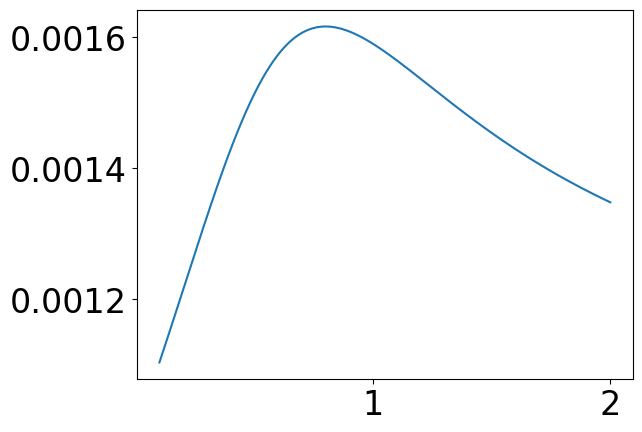

In [ ]:
from matplotlib import pyplot as plt
from tqdm import tqdm
# plot for c < 1  (M < N)

c = 2
N = 1000
M = 1000
Ntst = 1000
thetatst = np.sqrt(Ntst)
# N = int(np.round(M/c))
mu = 0.1
# opt_theta = np.sqrt(optimal_theta(c,mu,thetatst,Ntst,M)/N)

# x = list(torch.linspace(0.5, 2.5, 11).cpu())
# # bias_true = []
# # wnorm_true = []
# # y_true = []
# # for idx,c in enumerate(x):
# #   N = int(np.round(M/c)) # Data Scaling
# #   # M = int(np.round(N*c)) # Parameter Scaling

# #   # theta = optimal_theta(c,mu,thetatst,Ntst,M)
# #   theta = np.sqrt(N)
# #   # y.append(calc_gen_error(c,mu,theta,thetatst,Ntst,M))
# #   err = sim(M,N,theta,thetatst,Ntst,mu,200)
# #   # bias_true.append(b.cpu())
# #   # wnorm_true.append(w.cpu())
# #   y_true.append(err.cpu())
# #   torch.save(y_true, "drive/MyDrive/mu-"+str(mu)+"-train-data-scaling.pt")
# # # y_true = torch.load("drive/MyDrive/mu-"+str(mu)+"c-"+str(c)+"-theta-scaling.pt")
# y_true = torch.load("drive/MyDrive/mu-"+str(mu)+"c-"+str(c)+"-theta-scaling.pt")
# # bias_true,wnorm_true = torch.load("drive/MyDrive/mu-"+str(mu)+"-bias-variance-parameter-scaling.pt")
# # y_true = torch.load("drive/MyDrive/mu-"+str(mu)+"-train-data-scaling.pt")

x2 = torch.linspace(0.1, 0.5, 1001).cpu()
mu = 0.5
cs = torch.linspace(0.1, 2, 1001).cpu()
y = torch.zeros(cs.shape[0])
y2 = torch.zeros(cs.shape[0])
# bias = torch.zeros(x2.shape[0])
# wnorm = torch.zeros(x2.shape[0])

for i,c in tqdm(list(enumerate(cs))):
  # for j,mu in enumerate(x2):

    N = int(np.round(M/c)) # Data Scaling
    # M = int(np.round(N*c)) # Parameter Scaling
    # theta = t*np.sqrt(N)
    theta = optimal_theta(c,mu,thetatst,Ntst,M)
    y[i] = theta**2/N
  #   bias[j] = calc_bias(c,mu,theta,thetatst,Ntst)
  #   wnorm[j] = calc_wnorm(c,mu,theta)
    y2[i] = calc_gen_error(c,mu,theta,thetatst,Ntst,M)

  #   # theta = np.sqrt(N)
  #   # y2.append(calc_gen_error(c,mu,theta,thetatst,Ntst,M))
  #   # y.append(calc_gen_error(c,mu,theta,thetatst,Ntst,M))
    # y[j] = calc_training_error(c,mu,theta,N)
  #   # y_true.append(sim(M,N,theta,thetatst,Ntst,mu,10))

# plt.plot(x2,y.cpu())
plt.plot(cs,y2)
# plt.scatter(x,y_true)
# # plt.axvline(x=1/(mu**2+1), color="g", linewidth = 5)

# # plt.yscale("log")

# opt_theta = optimal_theta(c,mu,thetatst,Ntst,M)

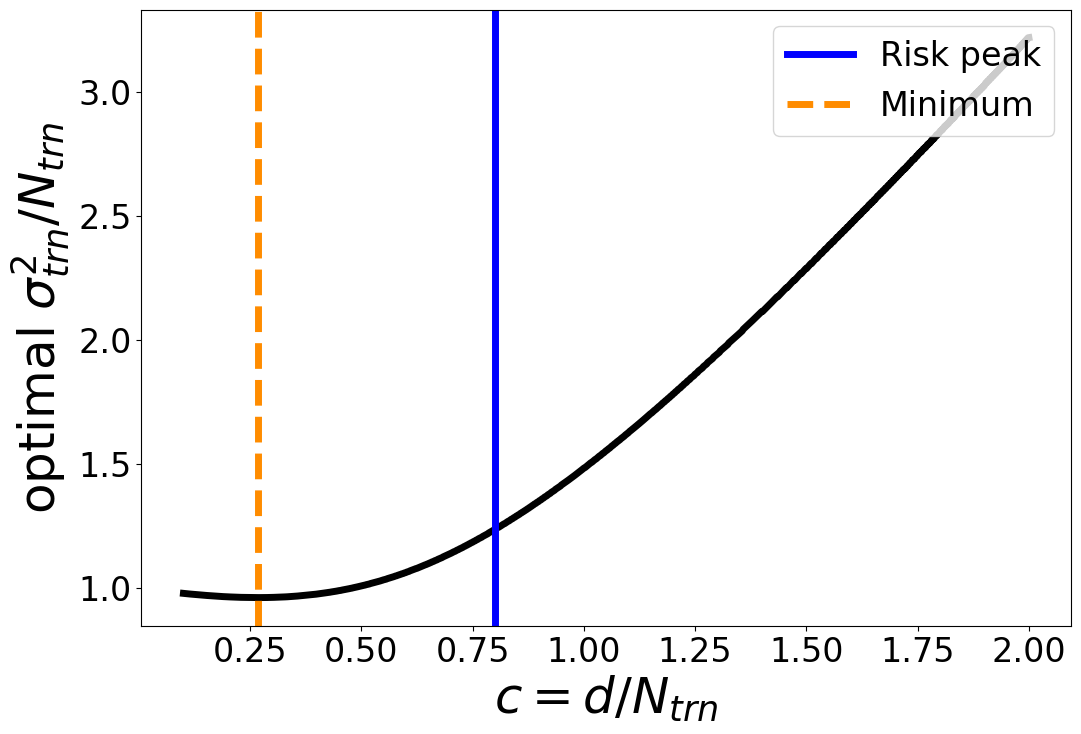

In [ ]:
fig,_ = plt.subplots(figsize =(12, 8))

plt.rc('xtick', labelsize=24)
plt.rc('ytick', labelsize=24)

plt.plot(cs,y.cpu(), linewidth = 5, color = "black")
plt.axvline(x=cs[y2.argmax()], color="b", linewidth = 5, label = "Risk peak")
plt.axvline(x=cs[y.argmin()], color = "darkorange", linestyle="dashed", linewidth=5, label = "Minimum")
plt.legend(fontsize = 24, loc="upper right")

plt.xlabel(r"$c = d/N_{trn}$", fontsize = 36)
plt.ylabel(r"optimal $\sigma_{trn}^2/N_{trn}$", fontsize = 36)

plt.savefig("mu-"+str(mu)+"-opt-that-data-scale.pdf", bbox_inches='tight', facecolor='white', dpi = 300, format = 'pdf')

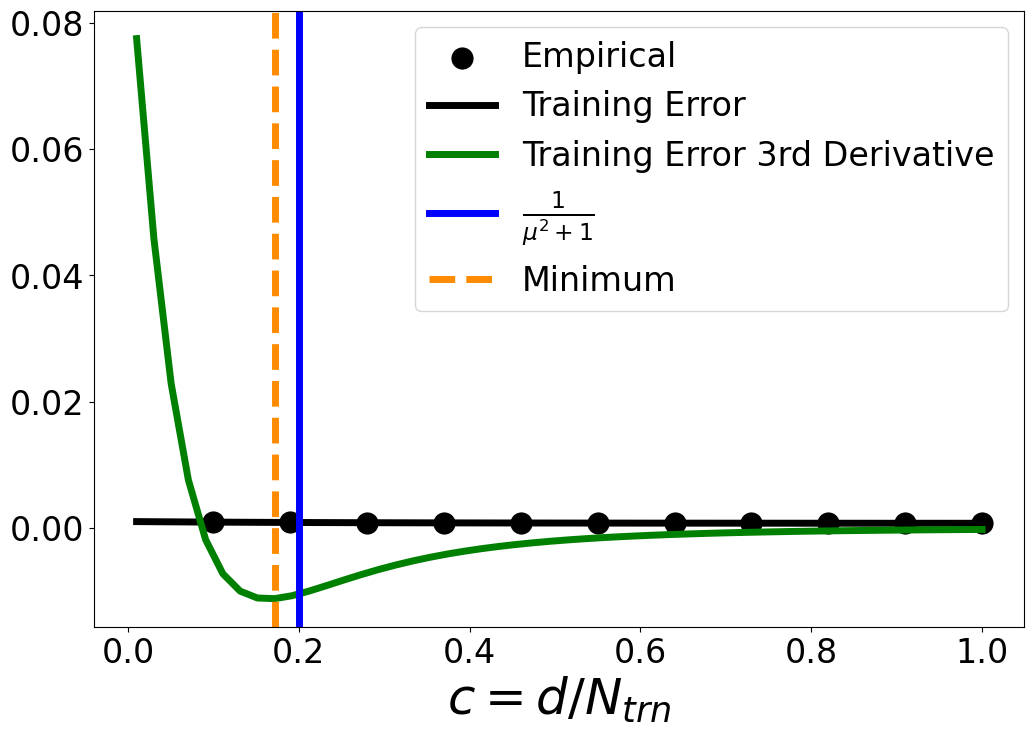

In [ ]:
fig,_ = plt.subplots(figsize =(12, 8))

plt.rc('xtick', labelsize=24)
plt.rc('ytick', labelsize=24)

c_values = torch.linspace(0.01,1,50).cpu()

plt.scatter(x,y_true, linewidth = 10, label = "Empirical", color = "black")
plt.plot(c_values,values[0,2,:].cpu(), linewidth = 5, label = "Training Error", color = "black")
plt.plot(c_values,values[3,2,:].cpu(), linewidth = 5, linestyle = "-", label = "Training Error 3rd Derivative", color = "green")

plt.axvline(x=1/(mu**2+1), color="b", linewidth = 5, label = r"$\frac{1}{\mu^2+1}$")
plt.axvline(x=c_values[values[3,2,:].argmin()], color = "darkorange", linestyle="dashed", linewidth=5, label = "Minimum")
plt.xlabel(r"$c = d/N_{trn}$", fontsize = 36)
# plt.ylabel(" Error", fontsize = 36)
# plt.axvspan(0, 1, color="green", alpha=0.2, lw=0)
# plt.text(0.2,0.008,"Under \nParameterized \nRegime", fontsize = 24)
plt.legend(fontsize = 24, loc="upper right")
# plt.yscale("symlog")
plt.savefig("mu-"+str(mu)+"-train-data-scale.pdf", bbox_inches='tight', facecolor='white', dpi = 300, format = 'pdf')

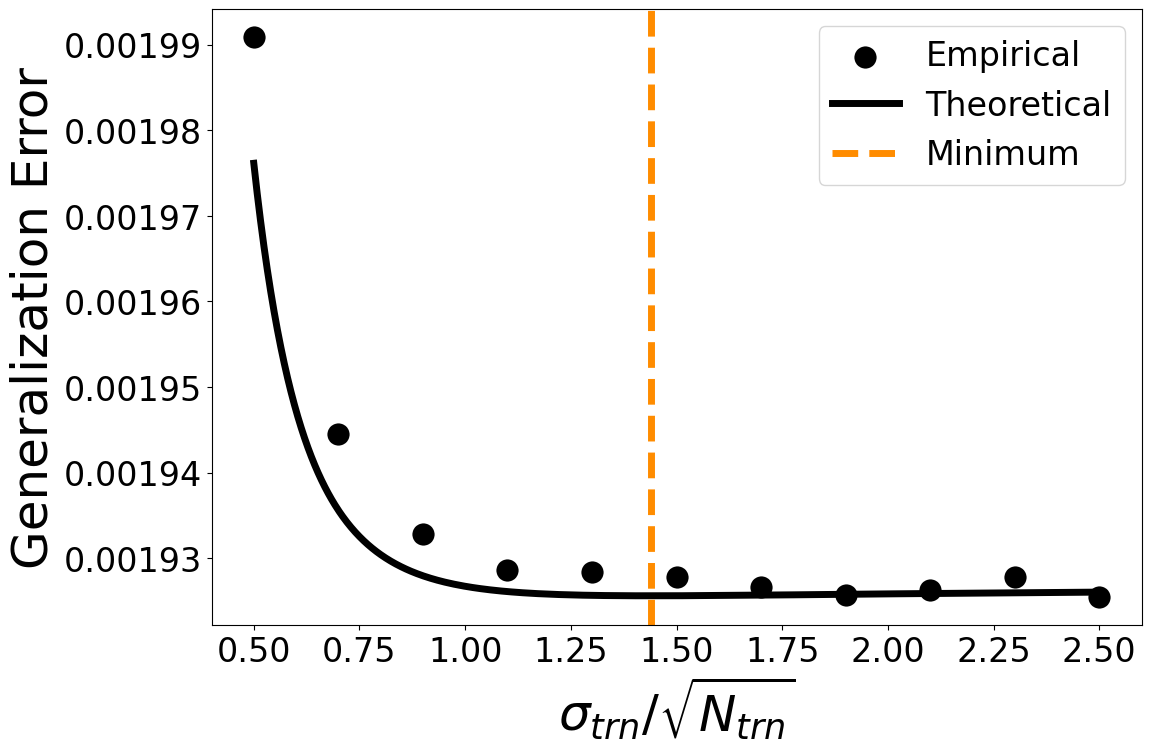

In [ ]:
fig,_ = plt.subplots(figsize =(12, 8))

plt.rc('xtick', labelsize=24)
plt.rc('ytick', labelsize=24)

plt.scatter(x,y_true, linewidth = 10, label = "Empirical", color = "black")
plt.plot(x2,y.cpu(), linewidth = 5, label = "Theoretical", color = "black")
# plt.axvline(x=1/(mu**2+1), color="b", linewidth = 5, label = r"$\frac{1}{\mu^2+1}$")
plt.axvline(x=x2[y.argmin()], color = "darkorange", linestyle="dashed", linewidth=5, label = "Minimum")
# plt.axvline(x=opt_theta/np.sqrt(2000), color = "darkorange", linestyle="dashed", linewidth=5, label = "Minimum 2")
plt.xlabel(r"$\sigma_{trn}/\sqrt{N_{trn}}$", fontsize = 36)
plt.ylabel("Generalization Error", fontsize = 36)
# plt.axvspan(0, 1, color="green", alpha=0.2, lw=0)
# plt.text(0.2,0.0011,"Under \nParameterized \nRegime", fontsize = 24)
plt.legend(fontsize = 24, loc="upper right")

plt.savefig("mu-"+str(mu)+"-c-"+str(c)+"-opt-theta-error-scale.pdf", bbox_inches='tight', facecolor='white', dpi = 300, format = 'pdf')

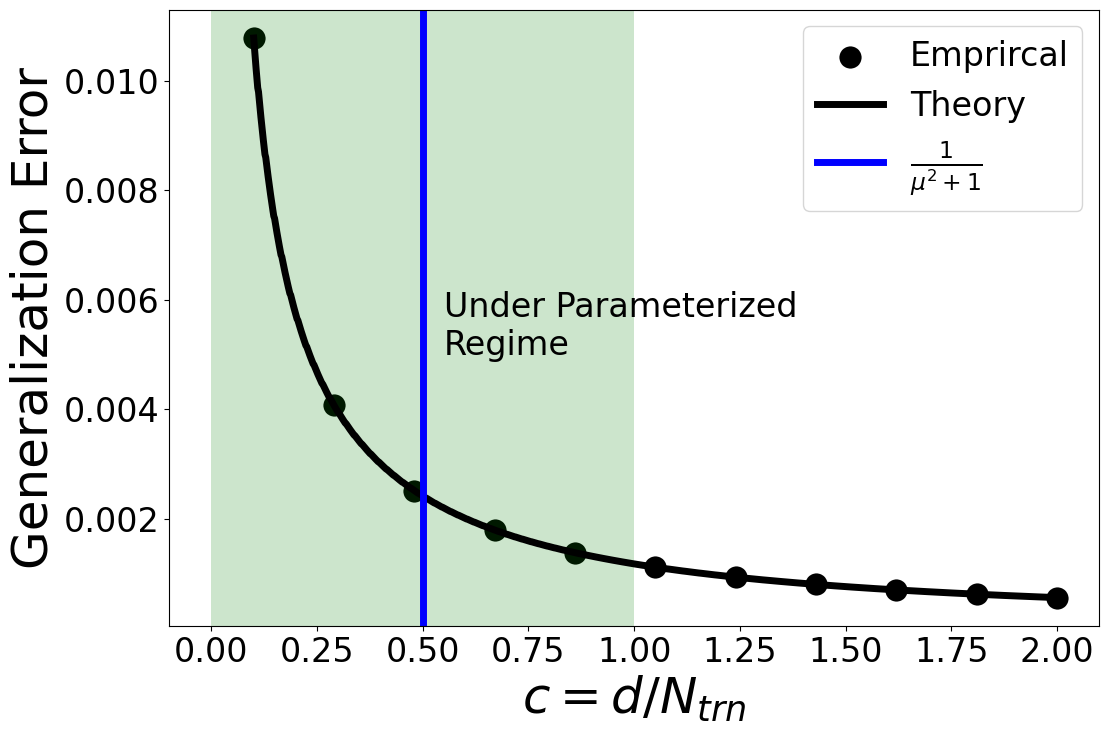

In [ ]:
fig,_ = plt.subplots(figsize =(12, 8))

plt.rc('xtick', labelsize=24)
plt.rc('ytick', labelsize=24)

Ms = N * torch.tensor(x)

plt.scatter(x,torch.tensor(wnorm_true)/Ms + torch.tensor(bias_true), label = "Emprircal", linewidth = 10, color = "black")
plt.plot(x2,y.cpu(), label = "Theory", linewidth = 5, color = "black")
plt.axvline(x=1/(mu**2+1), color="blue", linewidth = 5, label = r"$\frac{1}{\mu^2+1}$")
plt.legend(fontsize = 24)
plt.xlabel(r"$c=d/N_{trn}$", fontsize = 36)
plt.axvspan(0, 1, color="green", alpha=0.2, lw=0)
plt.text(0.55,0.005,"Under Parameterized \nRegime", fontsize = 24)
plt.ylabel(r"Generalization Error", fontsize = 36)
plt.savefig("mu-"+str(mu)+"-error-tradeoff-parameter-scale.pdf", bbox_inches='tight', facecolor='white', dpi = 300, format = 'pdf')

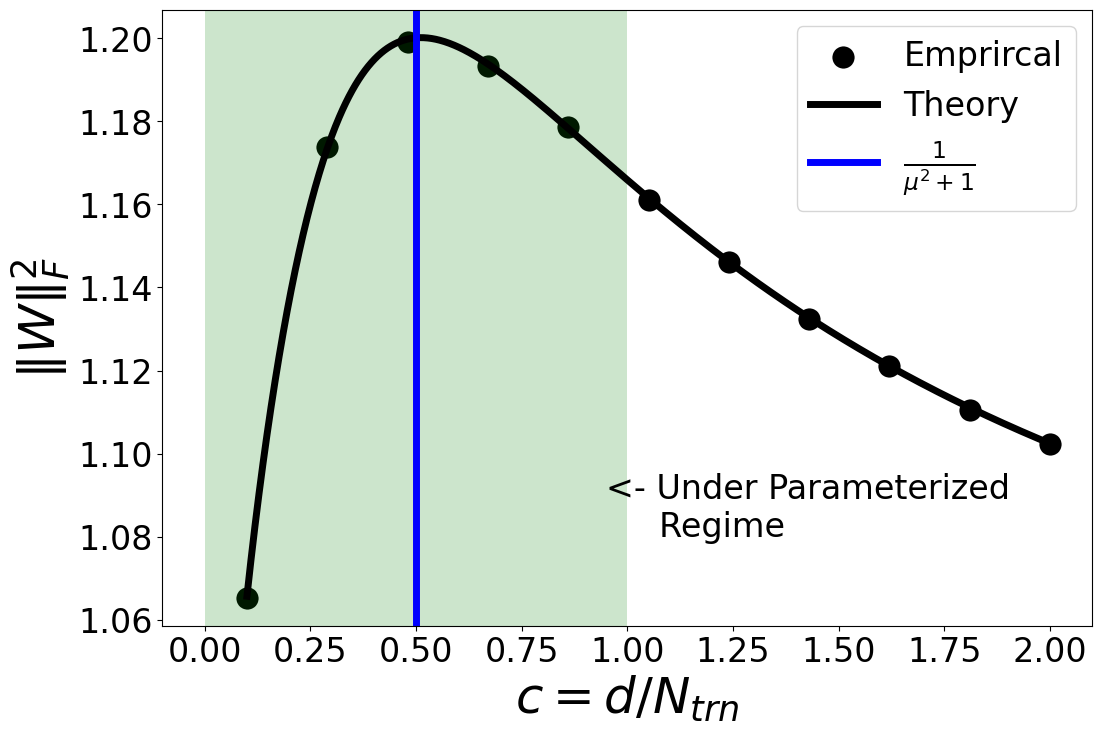

In [ ]:
fig,_ = plt.subplots(figsize =(12, 8))

plt.rc('xtick', labelsize=24)
plt.rc('ytick', labelsize=24)

plt.scatter(x,wnorm_true, label = "Emprircal", linewidth = 10, color = "black")
plt.plot(x2,wnorm.cpu(), label = "Theory", linewidth = 5, color = "black")
plt.axvline(x=1/(mu**2+1), color="blue", linewidth = 5, label = r"$\frac{1}{\mu^2+1}$")
plt.legend(fontsize = 24)
plt.xlabel(r"$c=d/N_{trn}$", fontsize = 36)
plt.axvspan(0, 1, color="green", alpha=0.2, lw=0)
plt.text(0.95,1.08,"<- Under Parameterized \n     Regime", fontsize = 24)
plt.ylabel(r"$\|W\|_F^2$", fontsize = 36)
plt.savefig("mu-"+str(mu)+"-variance-tradeoff-parameter-scale.pdf", bbox_inches='tight', facecolor='white', dpi = 300, format = 'pdf')

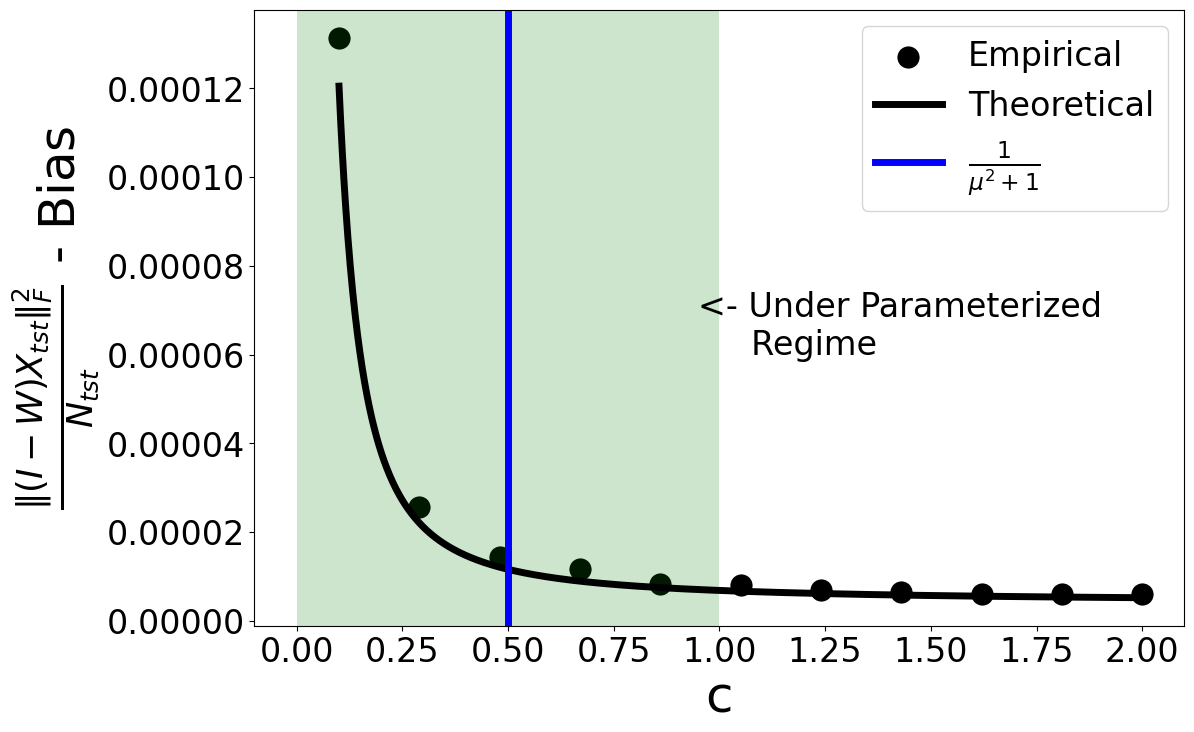

In [ ]:
fig,_ = plt.subplots(figsize =(12, 8))

plt.rc('xtick', labelsize=24)
plt.rc('ytick', labelsize=24)

plt.scatter(x,bias_true, linewidth = 10, label = "Empirical", color = "black")
plt.plot(x2,bias.cpu(), linewidth = 5, label = "Theoretical", color = "black")
plt.axvline(x=1/(mu**2+1), color="b", linewidth = 5, label = r"$\frac{1}{\mu^2+1}$")
plt.legend(fontsize = 24)
plt.xlabel("c", fontsize = 36)
plt.axvspan(0, 1, color="green", alpha=0.2, lw=0)
plt.text(0.95,0.00006,"<- Under Parameterized \n     Regime", fontsize = 24)
plt.ylabel(r"$\frac{\|(I-W)X_{tst}\|_F^2}{N_{tst}}$ - Bias", fontsize = 36)
plt.savefig("mu-"+str(mu)+"-bias-tradeoff-parameter-scale.pdf", bbox_inches='tight', facecolor='white', dpi = 300, format = 'pdf')

In [ ]:
slopes = torch.zeros(11)
y = y.cpu()
x2 = x2.cpu()
for i in range(11):
  slopes[i] = ((y[i,10:]-y[i,9:-1])/(x2.square()[10:] - x2.square()[9:-1])).mean().item()

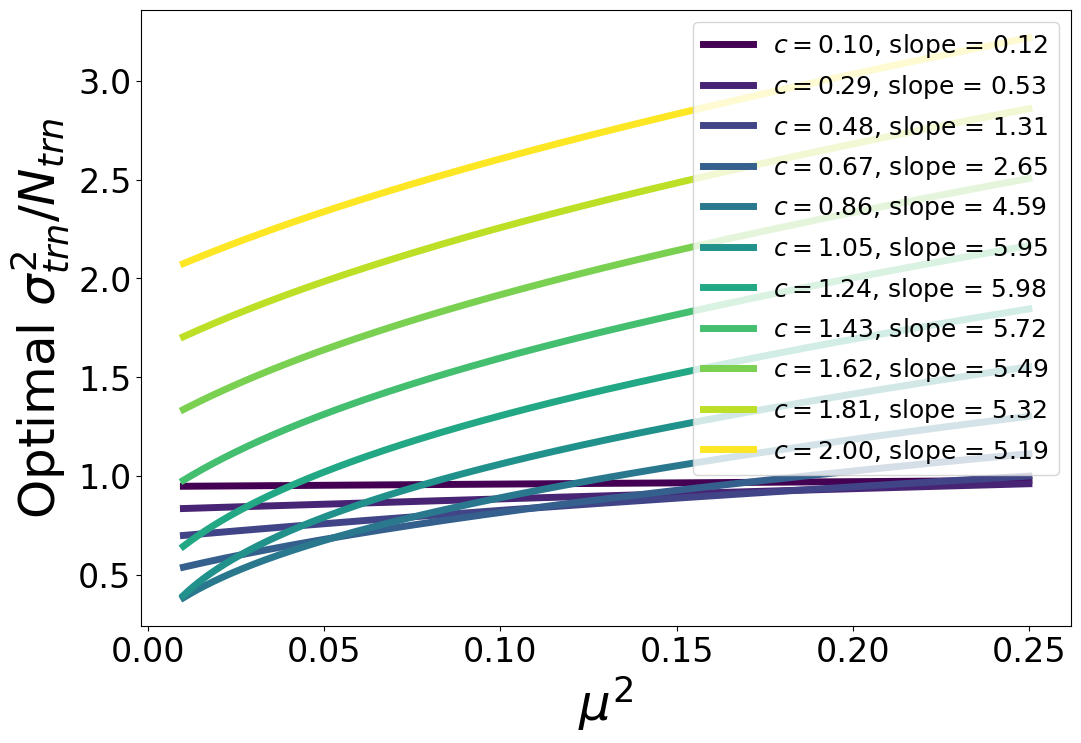

In [ ]:
fig,_ = plt.subplots(figsize =(12, 8))

cmap = plt.get_cmap("viridis")
sliced_cmap = cmap(np.linspace(0,1,11))

y = y.cpu()
# plt.yscale("log")
# plt.plot(x2,y, linewidth = 5, label = "Theoretical")

for i in range(11):
  plt.plot(x2*x2,y[i,:], linewidth = 5, label = r'$c= %.2f$, slope = %.2f' % (cs[i].item(), slopes[i].item()), c=sliced_cmap[i])
# plt.plot(x2*x2,y[1,:], linewidth = 5, label = r'$c= %.2f$' % cs[1].item(), c=sliced_cmap[1])
# plt.plot(x2*x2,y[2,:], linewidth = 5, label = r'$c= %.2f$' % cs[2].item(), c=sliced_cmap[2])
# plt.plot(x2*x2,y[3,:], linewidth = 5, label = r'$c= %.2f$' % cs[3].item(), c=sliced_cmap[3])
# plt.plot(x2*x2,y[4,:], linewidth = 5, label = r'$c= %.2f$' % cs[4].item(), c=sliced_cmap[4])
# plt.plot(x2*x2,y[5,:], linewidth = 5, label = r'$c= %.2f$' % cs[5].item(), c=sliced_cmap[5])
# plt.plot(x2*x2,y[6,:], linewidth = 5, label = r'$c= %.2f$' % cs[6].item(), c=sliced_cmap[6])
# plt.plot(x2*x2,y[7,:], linewidth = 5, label = r'$c= %.2f$' % cs[7].item(), c=sliced_cmap[7])
# plt.plot(x2*x2,y[8,:], linewidth = 5, label = r'$/c= %.2f$' % cs[8].item(), c=sliced_cmap[8])
# plt.plot(x2*x2,y[9,:], linewidth = 5, label = r'$c= %.2f$' % cs[9].item(), c=sliced_cmap[9])
# plt.plot(x2*x2,y[10,:], linewidth = 5, label = r'$c= %.2f$' % cs[10].item(), c=sliced_cmap[10])
# plt.scatter(x,y_true, linewidth = 10, label = "Empirical")
plt.ylabel(r"Optimal $\sigma_{trn}^2/N_{trn}$", fontsize=36)
plt.xlabel(r'$\mu^2$', fontsize=36)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
# plt.title("mu = "+str(mu), fontsize=24)
# plt.axvline(x=1/(mu**2+1), color="r", linewidth = 5, label = r"$\frac{1}{\mu^2+1}$")
# plt.axvline(x=x2[np.argmax(y[400:])+400], color="g", linewidth = 5, label = "Peak")
plt.legend(fontsize = 18)
plt.savefig("opt-theta-mu-small-data-scale.pdf", bbox_inches='tight', facecolor='white', dpi = 300, format = 'pdf')

In [ ]:
M = 1000
N = 1000
Ntst = 1000
thetatst = np.sqrt(Ntst)
theta = np.sqrt(Ntst)

cs = torch.linspace(0.1,1,1001)
mus = [0.1,1,2] #torch.linspace(0.1,10,101).cpu()

errors = torch.zeros(3,1001)
wnorm = torch.zeros(3,1001)

for i,mu in tqdm(enumerate(mus)):
  for j,c in enumerate(cs):
    # N = int(np.round(M/c))
    M = int(np.round(N*c))
    theta = np.sqrt(N)
    errors[i,j] = (calc_gen_error(c,mu,theta,thetatst,Ntst,M))
    wnorm[i,j] = calc_wnorm(c,mu,theta)

3it [00:17,  5.89s/it]


<ipython-input-122-b365f656de3a>:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("viridis")


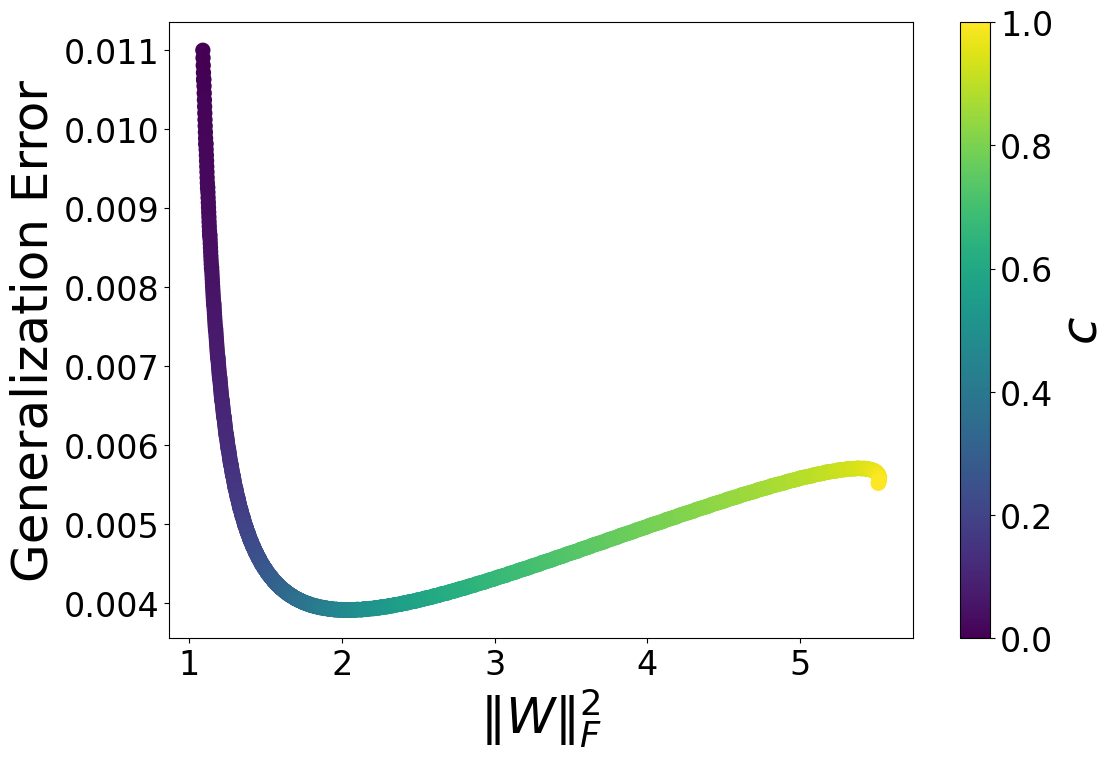

In [ ]:
from matplotlib import cm, colors

# define color map
cmap = cm.get_cmap("viridis")

# need to normalize because color maps are defined in [0, 1]
norm = colors.Normalize(0, 1001)

fig,_ = plt.subplots(figsize =(12, 8))

plt.rc('xtick', labelsize=24)
plt.rc('ytick', labelsize=24)

plt.scatter(wnorm[0,:], errors[0,:], linewidth = 5, c = cmap(norm(range(1001))))
# plt.axvline(x=cs[y2.argmax()], color="b", linewidth = 5, label = "Risk peak")
# plt.axvline(x=cs[y.argmin()], color = "darkorange", linestyle="dashed", linewidth=5, label = "Minimum")
# plt.legend(fontsize = 24, loc="upper right")

plt.xlabel(r"$\|W\|_F^2$", fontsize = 36)
plt.ylabel(r"Generalization Error", fontsize = 36)
plt.colorbar().set_label(label=r"$c$",size=36)

plt.savefig("mu-"+str(0.1)+"-wnorm-error-parameter-scale.pdf", bbox_inches='tight', facecolor='white', dpi = 300, format = 'pdf')